<a href="https://colab.research.google.com/github/Mainakdeb/Facial_Expression_Classification/blob/master/FER_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!git clone https://github.com/Mainakdeb/Facial_Expression_Classification.git

In [0]:
import sys, os
import pandas as pd
import numpy as np
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from tqdm import tnrange, tqdm_notebook, tqdm

from IPython.display import clear_output

In [83]:
df=pd.read_csv('/content/drive/My Drive/Emotion Recognition/fer2013.csv')

print(df.info())
print(df["Usage"].value_counts())
df

#Usage => Training, PrivateTest==val, PublicTest==test
# fer2013.csv => pandas dataframe => balance dataset => convert back to csv

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB
None
Training       28709
PrivateTest     3589
PublicTest      3589
Name: Usage, dtype: int64


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


In [84]:
print(df["emotion"].value_counts()) # unbal

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64


In [85]:
max_size = df['emotion'].value_counts().max()
lst = [df]
for class_index, group in df.groupby('emotion'):
    lst.append(group.sample(max_size-len(group), replace=True))
frame_new = pd.concat(lst)
import torch.nn.functional as F
df2=frame_new
print(df2["emotion"].value_counts()) # balanced
df3=df2.sample(frac=1) # randomise

6    8989
5    8989
4    8989
3    8989
2    8989
1    8989
0    8989
Name: emotion, dtype: int64


In [86]:
df3.head()

,emotion,pixels,Usage
24661,6,73 60 58 61 59 57 80 92 104 116 117 98 90 100 ...,Training
18374,1,252 255 253 254 254 254 252 255 228 191 189 19...,Training
14956,6,116 118 119 119 119 121 121 122 125 125 126 13...,Training
13750,4,12 12 12 12 12 12 12 11 11 10 11 11 11 10 10 1...,Training
3853,3,38 41 48 49 58 83 78 96 96 90 106 116 97 83 86...,Training


In [95]:
df3.to_csv('./fer_balanced.csv') 
df3.head()

,emotion,pixels,Usage
24661,6,73 60 58 61 59 57 80 92 104 116 117 98 90 100 ...,Training
18374,1,252 255 253 254 254 254 252 255 228 191 189 19...,Training
14956,6,116 118 119 119 119 121 121 122 125 125 126 13...,Training
13750,4,12 12 12 12 12 12 12 11 11 10 11 11 11 10 10 1...,Training
3853,3,38 41 48 49 58 83 78 96 96 90 106 116 97 83 86...,Training


In [0]:
!rm -r fer_images
!mkdir -p fer_images/0
!mkdir -p fer_import/1
!mkdir -p fer_images/2
!mkdir -p fer_images/3
!mkdir -p fer_images/4
!mkdir -p fer_images/5
!mkdir -p fer_images/6

In [0]:
fer_data=pd.read_csv('./fer_balanced.csv',delimiter=',')
def save_fer_img():
    print("Please wait...")

    for index,row in fer_data.iterrows():
        pixels=np.asarray(list(row['pixels'].split(' ')),dtype=np.uint8)
        img=pixels.reshape((48,48))

        if row['emotion'] < 6:
          pathname=os.path.join('fer_images/'+str(row['emotion']+1) ,str(index)+'.jpg')
        else:
          pathname=os.path.join('fer_images/'+str(0) ,str(index)+'.jpg')

        cv2.imwrite(pathname,img)
        
    print("Done")
    print("Sample_pathname=>", pathname)

In [106]:
save_fer_img()

Please wait...
Done
Sample_pathname=> fer_images/3/62922.jpg


In [107]:
!pip install augmentor

In [108]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import Augmentor

p = Augmentor.Pipeline()
p.flip_left_right(probability=0.9)
p.rotate(probability=0.7, max_left_rotation=12, max_right_rotation=12)
p.zoom_random(0.8, percentage_area=0.99)
p.random_distortion(probability=1, grid_width=4, grid_height=4, magnitude=1)


transformations_n = transforms.Compose([
    p.torch_transform(),                                    
    transforms.Grayscale(num_output_channels=1),                          
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    

])

data = torchvision.datasets.ImageFolder(root='fer_images/', transform=transformations_n)
print(len(data))

53934


Label: 4


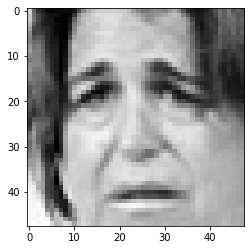

In [109]:
#53934-500

train_set, val_set = torch.utils.data.random_split(data, [53434, 500])

sample = next(iter(train_set))
image,label = sample #sequence unpacking
plt.imshow(image.squeeze(), cmap="gray")
print("Label:", label)

Challenges in Representation Learning: Facial Expression Recognition Challenge

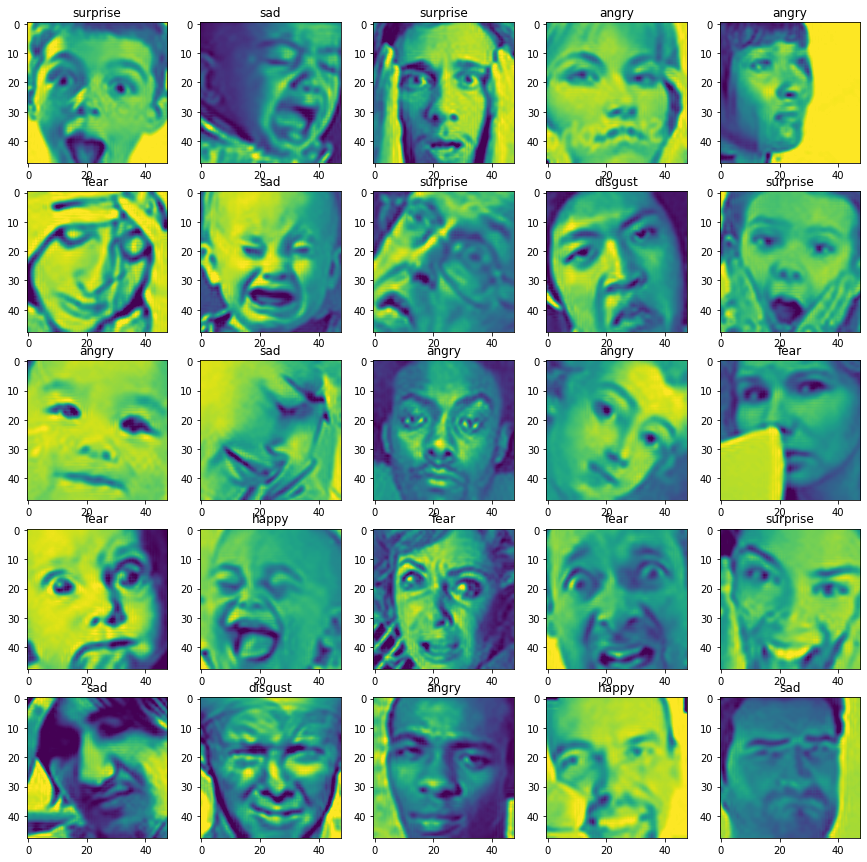

<Figure size 720x216 with 0 Axes>

<Figure size 3600x3600 with 0 Axes>

In [123]:
train_loader = torch.utils.data.DataLoader(
    train_set
    ,batch_size=5
    ,shuffle=True
)

emotions = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

fig, axs = plt.subplots(5, 5, figsize=(15,15))
fig = plt.figure(figsize=(10,3))
trans = transforms.ToPILImage()
plt.figure(figsize=(50,50))

for i in range(5):
    for j in range(5):
        for image_list in (train_loader):
            np_image=image_list[0][0]
            label_tensor=image_list[1][0]

            max_index = (label_tensor.item())
            label_emotion = emotions[max_index]

            x=np_image.squeeze()
            axs[j,i].imshow(x, interpolation='sinc')

            axs[j,i].title.set_text(label_emotion)
            break
plt.show()

In [0]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=0,)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 9 * 9, 300)
        self.fc2 = nn.Linear(300, 60)
        self.fc3 = nn.Linear(60, 7)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        #print(x.shape)
        x = x.view(-1, 16 * 9 * 9)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

network=Network()

In [0]:
train_loader = torch.utils.data.DataLoader(
    train_set
    ,batch_size=50
    ,shuffle=True
)

val_loader = torch.utils.data.DataLoader(
    val_set, 
    batch_size=500, 
    shuffle=True
)

loss_list=[]
acc_list=[]
val_loss_list=[]
val_acc_list=[]

optimizer = optim.Adam(network.parameters(), lr=0.0008)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=4)


In [0]:
for epoch in tnrange(10):
    
    total_loss = 0
    total_correct = 0
    total_loss2 = 0.
    total_correct2 = 0

    for batch in tqdm_notebook(train_loader): # Get Batch
        images, labels = batch 

        preds = network(images) # Pass Batch
        loss = F.cross_entropy(preds, labels) # Calculate Loss

        optimizer.zero_grad()
        loss.backward() # Calculate Gradients
        optimizer.step() # Update Weights

        total_loss += loss.item()
        total_correct += get_num_correct(preds, labels)

    with torch.no_grad():
      #print("Validating......")
      network.eval()
      for batch2 in (val_loader): # Get Batch
          images2, labels2 = batch2
          preds2 = network(images2) # Pass Batch

          loss2 = F.cross_entropy(preds2, labels2)

          total_loss2 += loss2.item()
          total_correct2 += get_num_correct(preds2, labels2)

    print(
        "epoch", epoch, 
        "total_correct:", total_correct, 
        #"loss:", total_loss/57000, 
        #"val_loss", total_loss2/3000,
        "val_correct", total_correct2
    )
    loss_list.append(total_loss/53434)
    acc_list.append(total_correct/53434)
    val_loss_list.append(total_loss2/500)
    val_acc_list.append(total_correct2/500)
    #clear_output(wait=True)


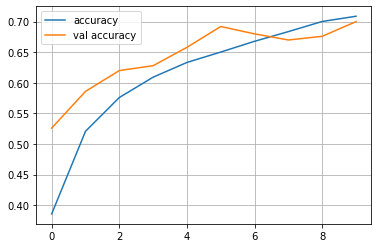

In [131]:
plt.plot(acc_list, label='accuracy')
plt.plot(val_acc_list, label = 'val accuracy')
plt.grid()
plt.legend()

In [0]:
emotions = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

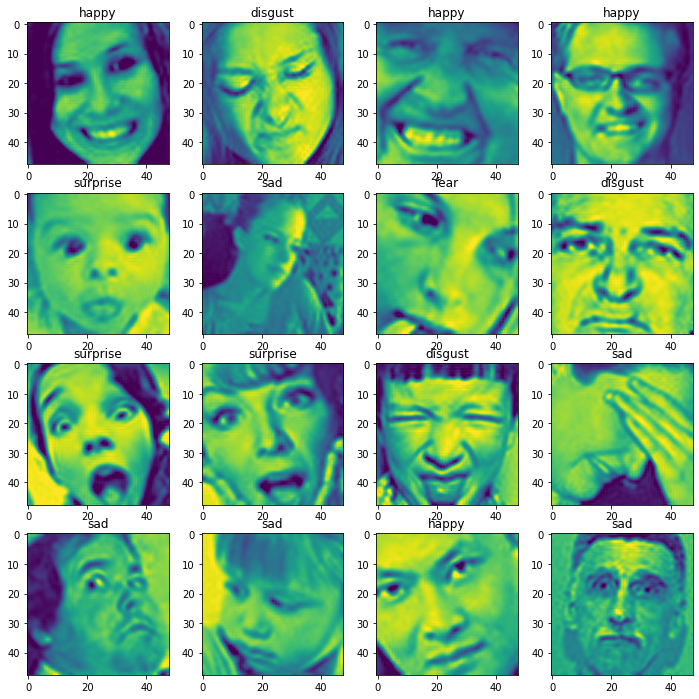

<Figure size 720x216 with 0 Axes>

<Figure size 3600x3600 with 0 Axes>

In [135]:
fig, axs = plt.subplots(4, 4, figsize=(12,12))
fig = plt.figure(figsize=(10,3))
trans = transforms.ToPILImage()
plt.figure(figsize=(50,50))

for i in range(4):
    for j in range(4):
        for image_list in (val_loader):
            p_image=image_list[0][0]
            x=p_image.squeeze()
            axs[j,i].imshow(x, interpolation='sinc')

            with torch.no_grad():
              network.eval()
              lab=network(p_image.unsqueeze(0))
              max_index = np.argmax(lab[0]) 
              predicted_emotion = emotions[max_index]
            
            axs[j,i].title.set_text(predicted_emotion)
            break
plt.show()

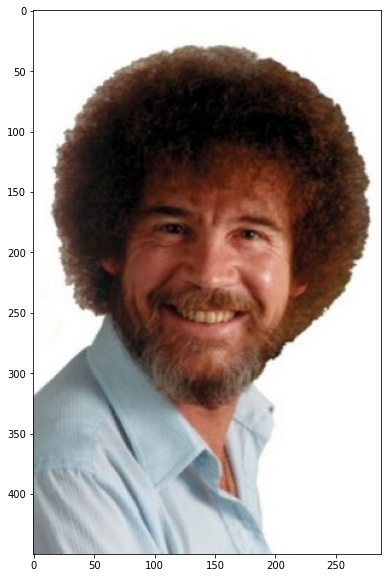

In [138]:
path = '/content/Facial_Expression_Classification/Smiling_Bob_Ross.jpg'
IMG_SIZE=100
test_img2 = cv2.imread(path)
plt.figure(figsize = (10,10))
plt.axis('on')
plt.imshow(test_img2)

# To fix weird colors
RGB_img = cv2.cvtColor(test_img2, cv2.COLOR_BGR2RGB)
plt.imshow(RGB_img)

torch.Size([1, 48, 48])


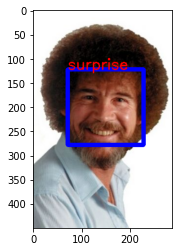

In [139]:
face_haar_cascade = cv2.CascadeClassifier('/content/Facial_Expression_Classification/haarcascade_frontalface_default.xml')
gray_img= cv2.cvtColor(test_img2, cv2.COLOR_BGR2GRAY)
faces_detected = face_haar_cascade.detectMultiScale(gray_img, 1.32, 5)

for (x,y,w,h) in faces_detected:
  
        cv2.rectangle(test_img2,(x,y),(x+w,y+h),(255,0,0),thickness=7)
        roi_gray=gray_img[y:y+w,x:x+h]#cropping region of interest i.e. face area from  image
        roi_gray=cv2.resize(roi_gray,(48,48))
        img_pixels = (roi_gray)
        img_pixels = np.expand_dims(img_pixels, axis = 0)
        p_image=torch.Tensor(img_pixels)
        img_pixels //= 255
        img_pixels=torch.Tensor(img_pixels)

        with torch.no_grad():

              network.eval()
              lab=network(img_pixels.unsqueeze(0))
              max_index = np.argmax(lab[0]) + 1        # +1 fixes a lot ??
              predicted_emotion = emotions[max_index]

        cv2.putText(test_img2, predicted_emotion, (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
        #resized_img = cv2.resize(test_img2, (700, 700))
        color_fixed = cv2.cvtColor(test_img2, cv2.COLOR_BGR2RGB)

print(img_pixels.shape)
plt.imshow(color_fixed)

In [0]:
torch.save(network.state_dict(), '/content/drive/My Drive/Emotion Recognition/models/model_l7.pt')

In [126]:
network.load_state_dict(torch.load('/content/drive/My Drive/Emotion Recognition/models/model_l7.pt'))

<All keys matched successfully>